<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
import pickle
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.manifold import TSNE
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

!unzip -q /content/gdrive/MyDrive/archive.zip -d ./images/

Mounted at /content/gdrive/


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive_path = '/content/gdrive/MyDrive/'
DATA_DIR = './images/'

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
def get_dataloader(image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  transforms = tt.Compose([
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats)
        ])

  data = ImageFolder(DATA_DIR, transform=transforms)
  dataloader = DataLoader(data, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  # info
  print(data)
  print('Размерность батча:', next(iter(dataloader))[0].shape)
  return dataloader

In [ ]:
#TODO: build dataloader and transfer it to device
image_size = 128
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

data_loader = get_dataloader(image_size, batch_size, stats)

Dataset ImageFolder
    Number of datapoints: 3143
    Root location: ./images/
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Размерность батча: torch.Size([16, 3, 128, 128])


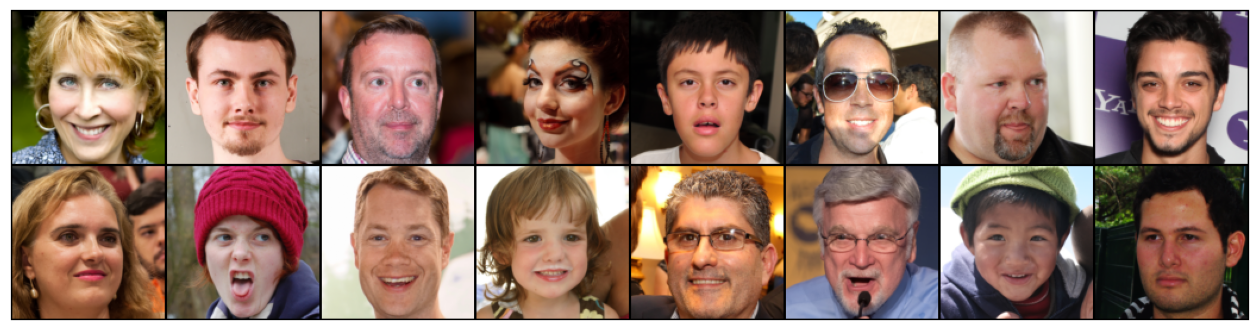

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

for images, _ in data_loader:
    show_images(images)
    break

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
latent_sizes = [
    60,
    120,
    #200
    ]

def Generator(latent_size: int):
    Generator = nn.Sequential(    # -> 1x1

        nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=2, padding=0, bias=False), # -> 4x4
        nn.BatchNorm2d(1024),
        nn.ReLU(True),

        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),         # -> 8x8
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),          # -> 16x16
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),          # -> 32x32
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),           # -> 64x64
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),             # -> 128x128
        nn.Tanh()
    )
    return Generator

In [ ]:
def Discriminator():
    Discriminator = nn.Sequential(   # -> 128x128

        nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),   # -> 64x64
        nn.Dropout(0.3),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),  # -> 32x32
        nn.Dropout(0.3),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # -> 16x16
        nn.Dropout(0.3),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # -> 8x8
        nn.Dropout(0.3),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # -> 4x4
        nn.Dropout(0.3),
        nn.LeakyReLU(inplace=True),

        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),   # -> 1x1

        nn.Flatten(),
        nn.Sigmoid()
        )
    return Discriminator

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-latent{}-{:0=4d}.png'.format(latent_size, index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr_d, lr_g, start_idx = 1):
    # TODO: build optimizers and train your GAN
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr_d, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr_g, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images, _ in tqdm(data_loader):
            #  #  #  #  #  #  #  #  #  #  #
            # Train discriminator
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images.to(device))
            # real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_targets = torch.full((real_images.size(0), 1), 0.95, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Pass fake images through discriminator
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            # fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_targets = torch.full((fake_images.size(0), 1), 0.05, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            #  #  #  #  #  #  #  #  #  #  #
            # Train generator
            optimizer["generator"].zero_grad()
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
            save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
epochs = 60
lr_d, lr_g = 0.0004, 0.0001

criterion = {
    "generator": nn.BCELoss(),
    "discriminator": nn.BCELoss()
}

for latent_size in latent_sizes:
    fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

    generator = Generator(latent_size).to(device)
    discriminator = Discriminator().to(device)
    model = {
        "generator": generator,
        "discriminator": discriminator,
    }
    history = fit(model, criterion, epochs, lr_d=lr_d, lr_g=lr_g)


    # Сохранение на Google-диск
    if (Path(drive_path) / 'losses_dict.pkl').exists():
        with open(Path(drive_path) / 'losses_dict.pkl', 'rb') as file:
            losses_dict = pickle.load(file)
    else:
        losses_dict = {}

    losses_dict[latent_size] = history

    with open(Path(drive_path) / 'losses_dict.pkl', 'wb') as file:
        pickle.dump(losses_dict, file)
    torch.save(
        model["generator"].state_dict(),
        Path(drive_path + str(f'/generator{latent_size}.pt'))
        )
    del generator, discriminator


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.8009, loss_d: 0.6065, real_score: 0.8784, fake_score: 0.1359


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 1.3959, loss_d: 0.9514, real_score: 0.7882, fake_score: 0.3503


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 1.2452, loss_d: 0.9922, real_score: 0.7468, fake_score: 0.3701


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 1.5594, loss_d: 0.9485, real_score: 0.7650, fake_score: 0.3399


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 1.5842, loss_d: 0.8687, real_score: 0.8067, fake_score: 0.3307


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 1.6833, loss_d: 0.8208, real_score: 0.8346, fake_score: 0.3096


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 1.7957, loss_d: 0.7599, real_score: 0.8601, fake_score: 0.2842


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 1.9621, loss_d: 0.7284, real_score: 0.8656, fake_score: 0.2590


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 1.7011, loss_d: 0.7916, real_score: 0.8666, fake_score: 0.3106


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 1.8919, loss_d: 0.7458, real_score: 0.8761, fake_score: 0.2790


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 1.7300, loss_d: 0.7572, real_score: 0.8820, fake_score: 0.3018


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 1.7602, loss_d: 0.7618, real_score: 0.8815, fake_score: 0.2979


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 1.6076, loss_d: 0.7808, real_score: 0.8829, fake_score: 0.3211


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 1.4292, loss_d: 0.8378, real_score: 0.8822, fake_score: 0.3609


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 1.4899, loss_d: 0.7795, real_score: 0.8997, fake_score: 0.3389


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 1.4713, loss_d: 0.7832, real_score: 0.9006, fake_score: 0.3389


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 1.7857, loss_d: 0.7454, real_score: 0.8993, fake_score: 0.2994


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 1.6214, loss_d: 0.7675, real_score: 0.9030, fake_score: 0.3221


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 1.7550, loss_d: 0.7344, real_score: 0.9042, fake_score: 0.2972


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 1.4849, loss_d: 0.7890, real_score: 0.9081, fake_score: 0.3473


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 1.6851, loss_d: 0.7432, real_score: 0.9124, fake_score: 0.3117


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 2.0349, loss_d: 0.6850, real_score: 0.9103, fake_score: 0.2568


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 1.6637, loss_d: 0.7386, real_score: 0.9141, fake_score: 0.3101


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 1.1483, loss_d: 0.8369, real_score: 0.9109, fake_score: 0.4010


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 1.2123, loss_d: 0.8342, real_score: 0.9073, fake_score: 0.3887


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 1.5073, loss_d: 0.7832, real_score: 0.9143, fake_score: 0.3431


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 1.5562, loss_d: 0.7537, real_score: 0.9177, fake_score: 0.3299


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 1.4579, loss_d: 0.7918, real_score: 0.9119, fake_score: 0.3508


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 1.2461, loss_d: 0.8250, real_score: 0.9160, fake_score: 0.3841


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 0.9946, loss_d: 0.8814, real_score: 0.9135, fake_score: 0.4339


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 1.4733, loss_d: 0.7794, real_score: 0.9191, fake_score: 0.3503


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 1.8189, loss_d: 0.7087, real_score: 0.9229, fake_score: 0.2868


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 1.6325, loss_d: 0.7419, real_score: 0.9263, fake_score: 0.3185


  0%|          | 0/197 [00:00<?, ?it/s]

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

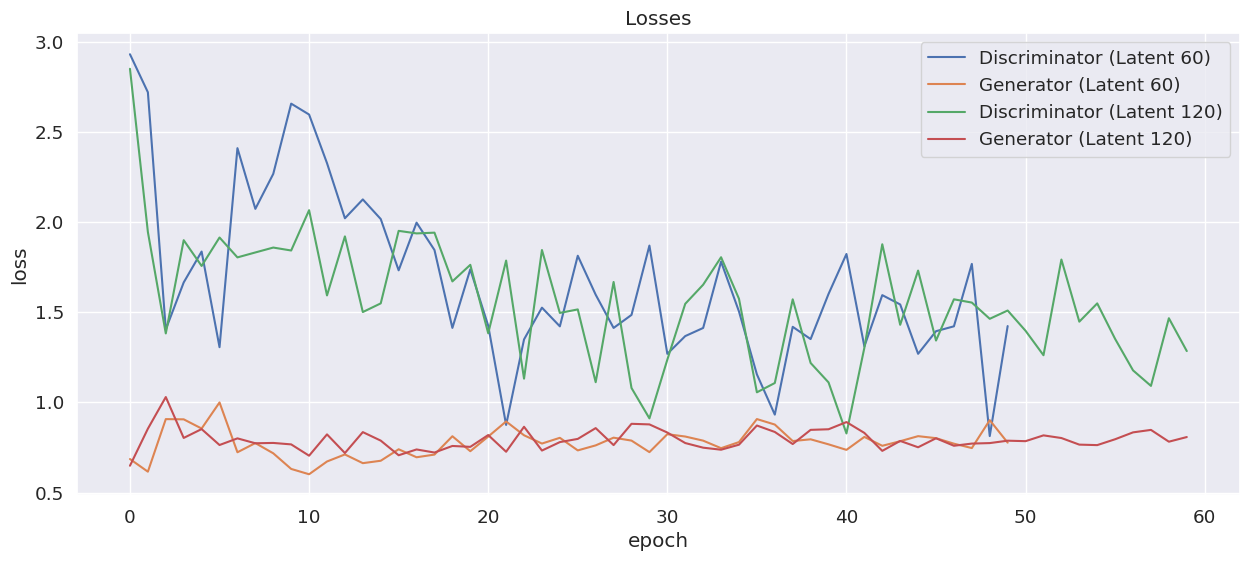

In [ ]:
def plot_losses(losses_dict):
    plt.figure(figsize=(15, 6))
    for latent_size, history in losses_dict.items():
        losses_d, losses_g, _, _ = history
        plt.plot(losses_d, label=f'Discriminator (Latent {latent_size})')
        plt.plot(losses_g, label=f'Generator (Latent {latent_size})')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses')
    plt.show()

plot_losses(losses_dict)

На графике изображены значения функции потерь в зависимости от размера латентного простанства.  Для потерь дискриминатора видна общая тенденция к большим колебаниям функции на первых порах обучения. Далее происходит снижение потерь, что говорит о приобретении способности дискриминатором отличать реальные и сгенерированные фото. Лосс генератора гораздо стабильнее - генератор учится медленно и постепенно генерировать лица. С течением обучения значения потерь как для дискриминатора, так и для генератора  приходят к состоянию равновесия.

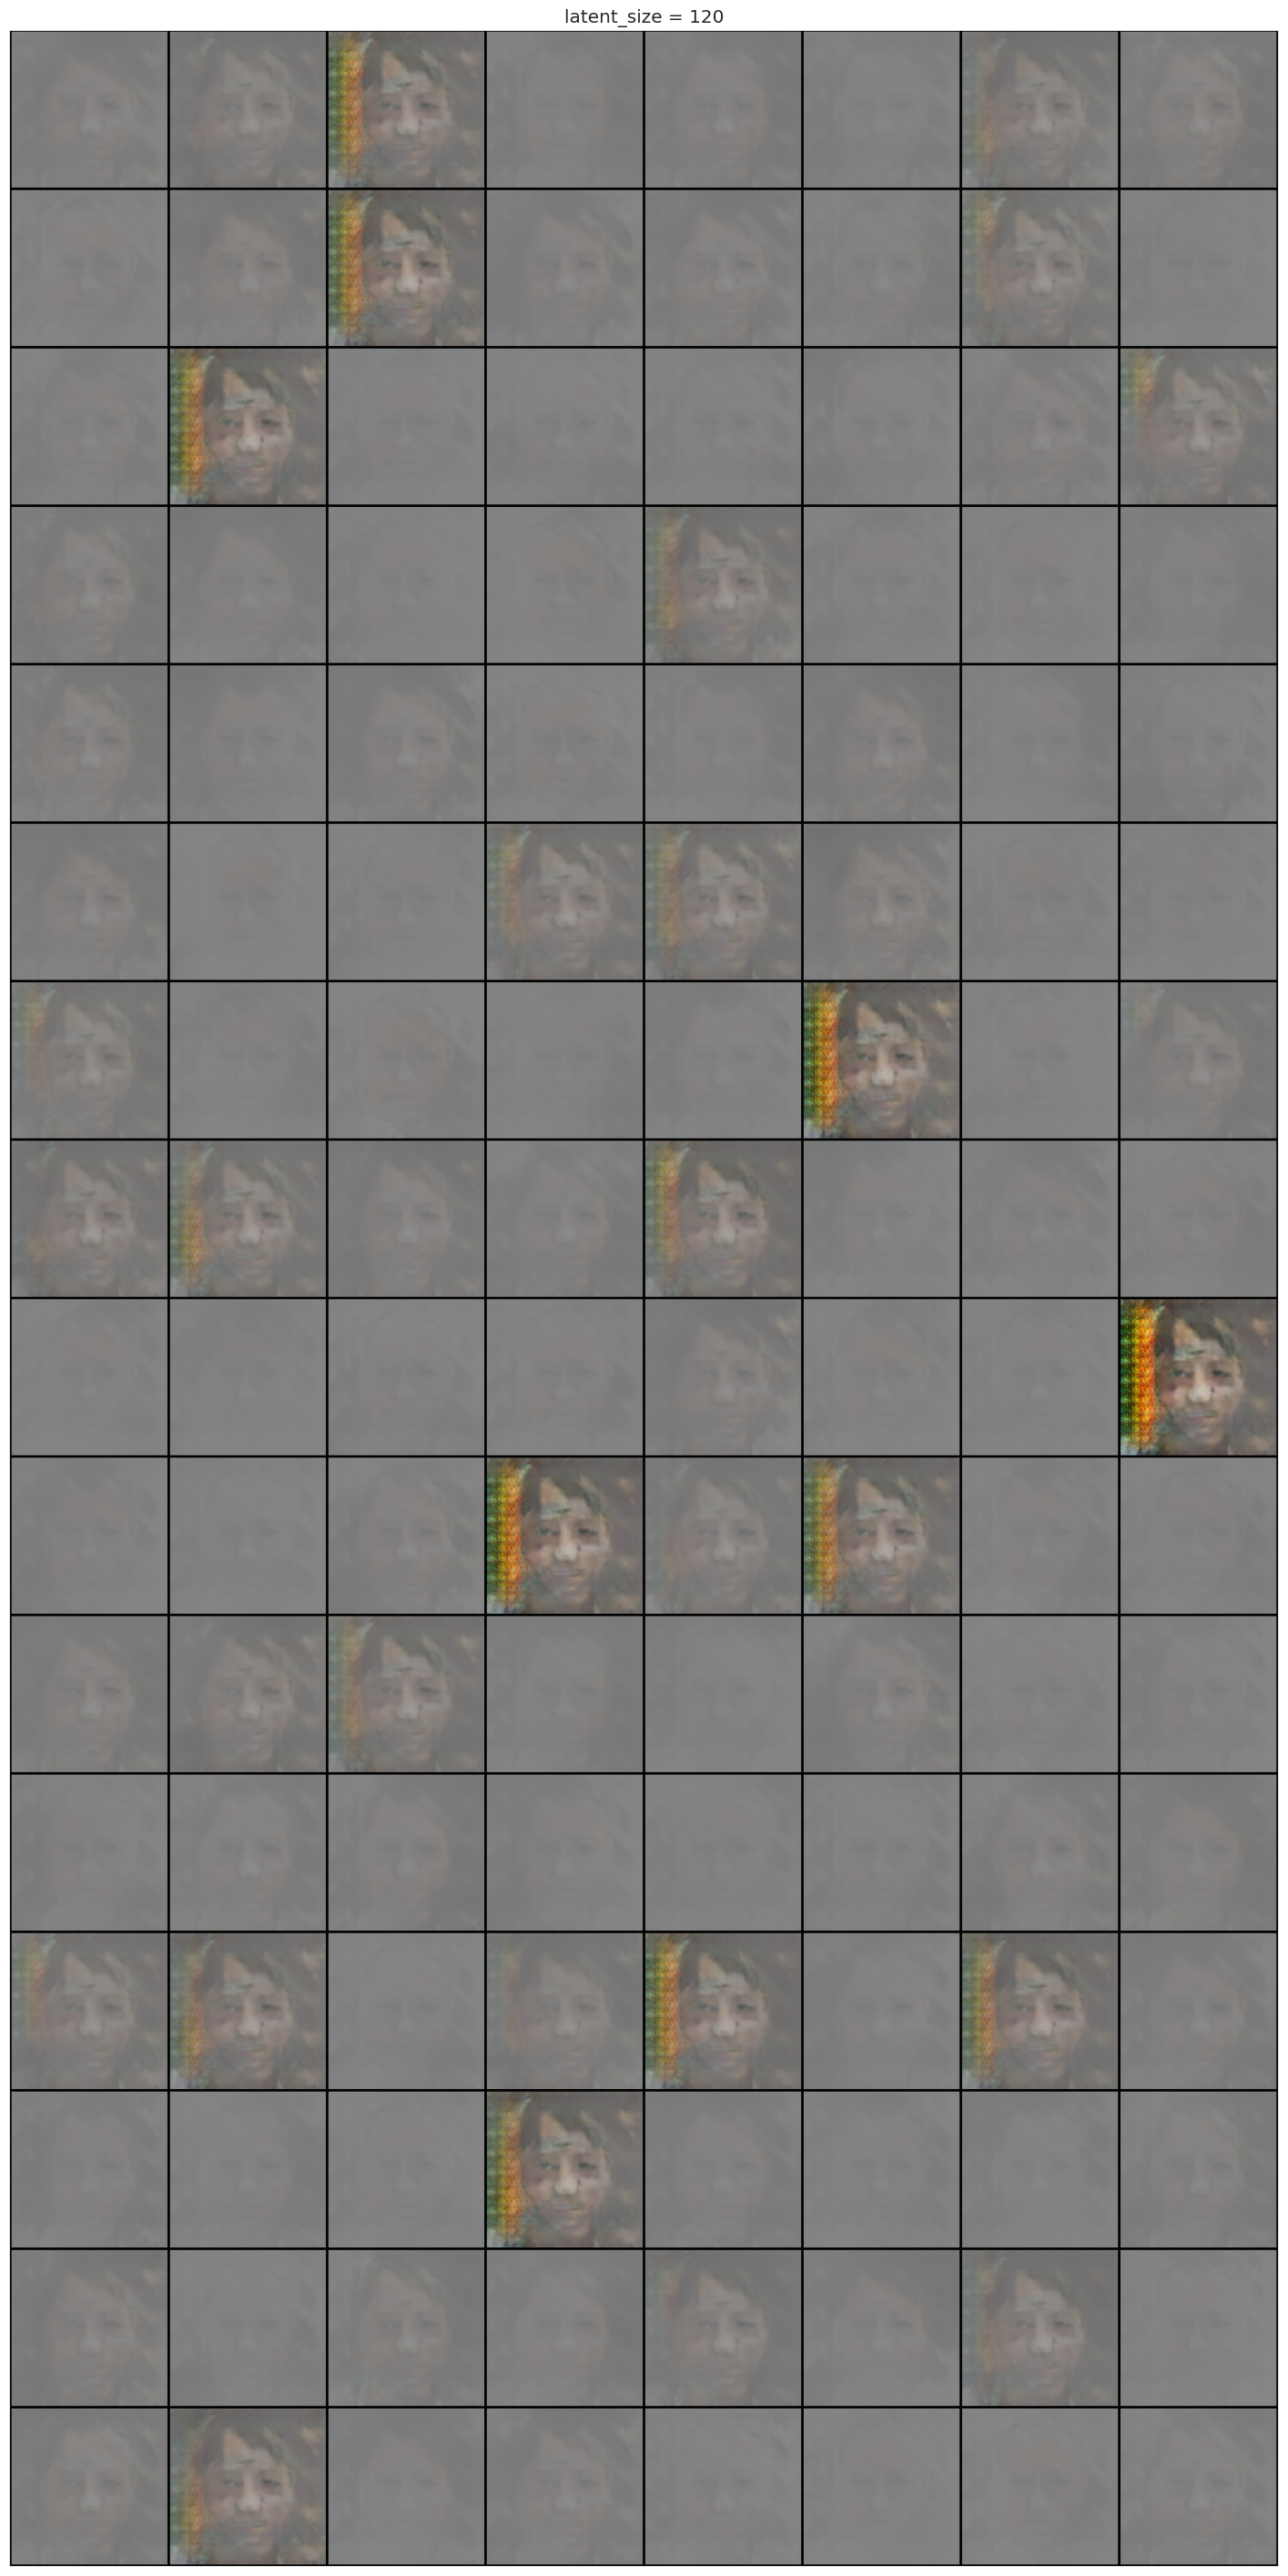

In [ ]:
def show_generated(latent_size):
    generated_img = cv2.imread(f'./generated/generated-images-latent{latent_size}-00{epochs}.png')
    generated_img = generated_img[:, :, [2, 1, 0]]

    fig, ax = plt.subplots(figsize=(18, 40))
    ax.set_title(f"latent_size = {latent_size}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(generated_img)

    plt.show()

show_generated(120)

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

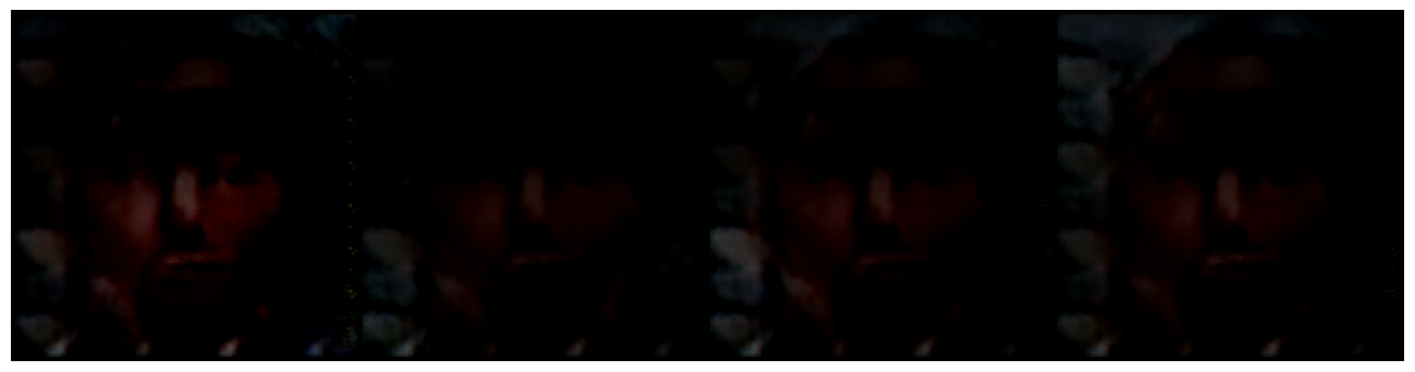

In [ ]:
def show_fake():

    n_images = 4
    fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
    generator = model['generator'].to(device)
    model["generator"].eval()
    fake_images = generator(fixed_latent)

    fig, ax = plt.subplots(figsize=(18, 40))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# latent_size = 60
show_fake()

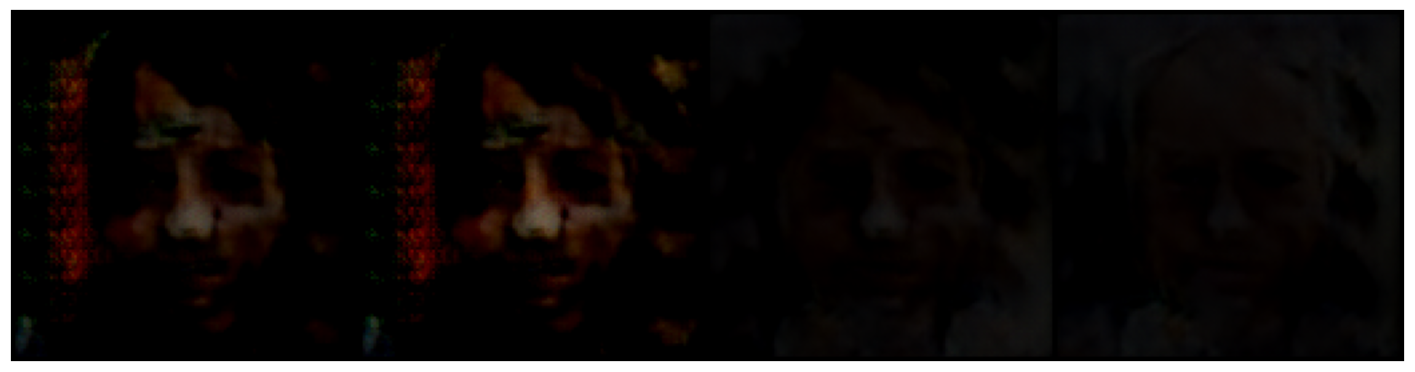

In [ ]:
# latent_size = 120
show_fake()

Как вам качество получившихся изображений?  
Похоже, модель научилась генерировать одно и то же человеческое лицо. Хотя с большим размером латентного вектора, лица выглядят немного разнообразнее.  
Мне удалось поэкспериментировать с двумя значениями latent size, в дальнейшем можно взять еще большие величины latent size, а также поварьировать гиперпараметры, что требует бОльших вычислительных ресурсов.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
# Загрузка сохраненных моделей
generators = [Generator(latent_size).to(device) for latent_size in latent_sizes]

for g, latent_size in zip(generators, latent_sizes):
    g.load_state_dict(torch.load(
        Path(drive_path + str(f'/generator{latent_size}.pt')), map_location=device))

In [ ]:
def get_dataset(image_size, stats):

    transforms = tt.Compose([
              tt.Resize(image_size),
              tt.CenterCrop(image_size),
              tt.ToTensor(),
              tt.Normalize(*stats)
          ])

    data = ImageFolder(DATA_DIR, transform=transforms)
    return data

dataset = get_dataset(image_size, stats)

In [ ]:
n = 1000

# real
real_images = [i[0] for i in tqdm(dataset)][:n]
real_images = torch.stack(real_images).reshape(n, -1)

  0%|          | 0/3143 [00:00<?, ?it/s]

In [ ]:
# fake
for generator, latent_size in zip(generators, latent_sizes):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(torch.randn(n, latent_size, 1, 1))
    fake_images = fake_images.reshape(n, -1)

# 1NN Classifier
    X = torch.concat([real_images.cpu(), fake_images.cpu()]).detach().numpy()
    y = torch.concat((torch.ones(n), torch.zeros(n))).numpy()

    scores = cross_val_score(KNeighborsClassifier(n_neighbors=1),
                X,
                y,
                cv=LeaveOneOut())

    print(f'Leave-one-out accuracy for latent size {latent_size}:', np.mean(scores))

Leave-one-out accuracy for latent size 120: 0.9275


Leave-one-out accuracy for latent size 60: 0.941


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?  
Независимый классификатор хорошо относит сгенерированные и реальные изображения к двум разным классам, accuracy cоставляет от 0.9. В идеале мы бы хотели получить accuracy не более 0.5, когда классификатор не может разделить реальные и фейковые изображения и определяет классы рандомно, с вероятностью 50%.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

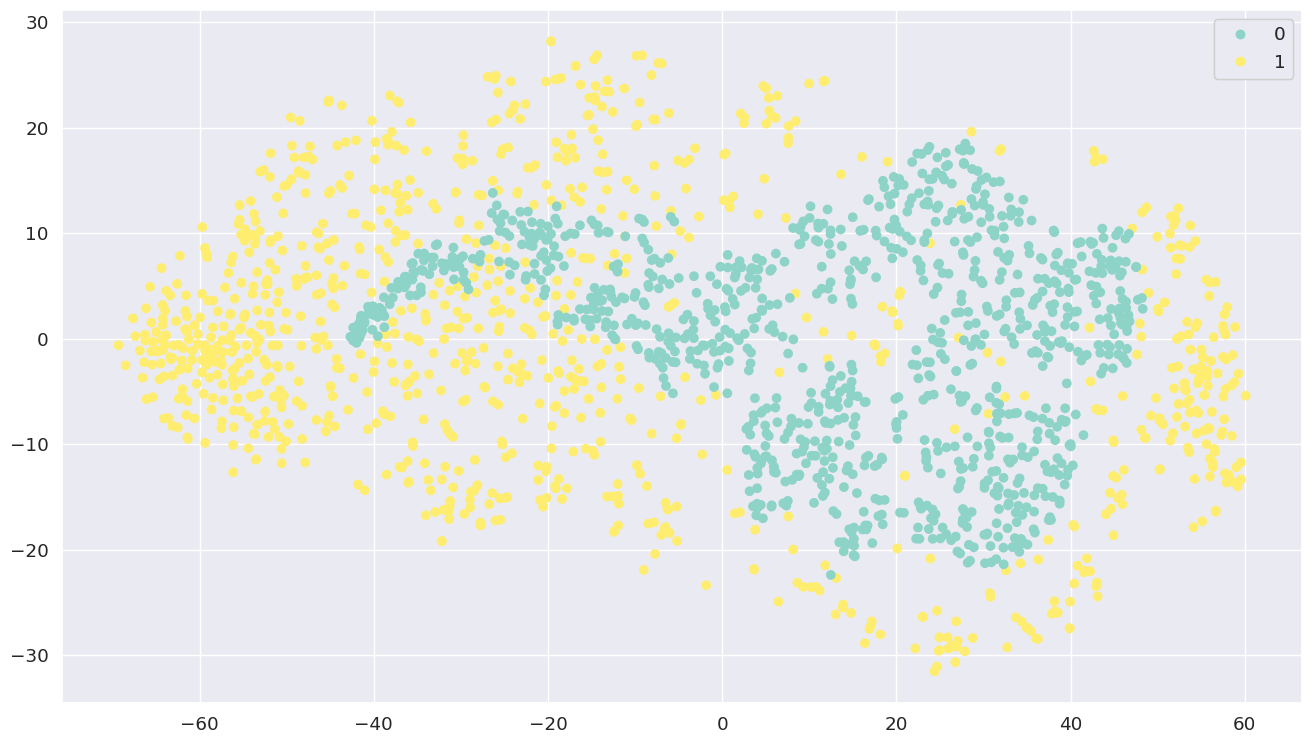

In [ ]:
tsne = TSNE(2)
z = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(16,9))
scatter = ax.scatter(x = z[:, 0], y = z[:, 1], c=y, cmap='Set3')
legend = ax.legend(*scatter.legend_elements(), loc="upper right")
ax.add_artist(legend)
plt.show()

Прокомментируйте получившийся результат:  
На рисунке метка "0" соответствует сгенерированным изображениям. Два облака точек, соответствующие двум классам изображений, заметно группируются друг с другом. В то же время есть "вклинивающаяся прослойка" фейковых фото в облако реальных. Возможно, именно эти фото соответствуют одному и тому же лицу, которое мы видели на картинках. Они как бы похожи на реальные лица, но классификатору лего научиться определять одно и тоже лицо как сгенерированное. В идеале точки должны быть полностью "перемешаны".